# Computer Vision - AV-HuBERT Downstream Task Research

## Install Modules
This section installs necessary python packages for the other sections. Run it first.

In [111]:
!git clone https://github.com/facebookresearch/av_hubert.git

!cd avhubert
!git submodule init
!git submodule update
!pip install scipy
!pip install sentencepiece
!pip install python_speech_features
!pip install scikit-video

%cd fairseq
%pip install ./

fatal: destination path 'av_hubert' already exists and is not an empty directory.
/bin/bash: line 0: cd: avhubert: No such file or directory
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
^C
ERROR: Operation cancelled by user
[Errno 2] No such file or directory: 'fairseq'
/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert
ERROR: Directory './' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.
Note: you may need to restart the kernel to use updated packages.


## Preprocess Dataset for AV-HuBERT

1. Install necessary tools for preprocessing

In [ ]:
# !mkdir -p ./data/misc/
# !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 -O ./data/misc/shape_predictor_68_face_landmarks.dat.bz2
# !bzip2 -d ./data/misc/shape_predictor_68_face_landmarks.dat.bz2
# !wget --content-disposition https://github.com/mpc001/Lipreading_using_Temporal_Convolutional_Networks/raw/master/preprocessing/20words_mean_face.npy -O ./data/misc/20words_mean_face.npy

2. Download a video from online

In [ ]:
# !wget --content-disposition https://dl.fbaipublicfiles.com/avhubert/demo/avhubert_demo_video_8s.mp4 -O ./data/clip.mp4

3. Extract mouth ROI.

In [2]:
%pwd

'/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert'

In [35]:
%cd av_hubert

/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/av_hubert


In [4]:
%cd ./av_hubert/avhubert/
# %cd ./avhubert

import dlib, cv2, os
import numpy as np
import skvideo
import skvideo.io
from tqdm import tqdm
from preparation.align_mouth import landmarks_interpolate, crop_patch, write_video_ffmpeg
from IPython.display import HTML
from base64 import b64encode

def play_video(video_path, width=200):
  mp4 = open(video_path,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML(f"""
  <video width={width} controls>
        <source src="{data_url}" type="video/mp4">
  </video>
  """)

def detect_landmark(image, detector, predictor):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    rects = detector(gray, 1)
    coords = None
    for (_, rect) in enumerate(rects):
        shape = predictor(gray, rect)
        coords = np.zeros((68, 2), dtype=np.int32)
        for i in range(0, 68):
            coords[i] = (shape.part(i).x, shape.part(i).y)
    return coords

def preprocess_video(input_video_path, output_video_path, face_predictor_path, mean_face_path):
  detector = dlib.get_frontal_face_detector()
  predictor = dlib.shape_predictor(face_predictor_path)
  STD_SIZE = (256, 256)
  mean_face_landmarks = np.load(mean_face_path)
  stablePntsIDs = [33, 36, 39, 42, 45]
  videogen = skvideo.io.vread(input_video_path)
  frames = np.array([frame for frame in videogen])
  landmarks = []
  for frame in tqdm(frames):
      landmark = detect_landmark(frame, detector, predictor)
      landmarks.append(landmark)
  preprocessed_landmarks = landmarks_interpolate(landmarks)
  rois = crop_patch(input_video_path, preprocessed_landmarks, mean_face_landmarks, stablePntsIDs, STD_SIZE, 
                        window_margin=12, start_idx=48, stop_idx=68, crop_height=96, crop_width=96)
  write_video_ffmpeg(rois, output_video_path, "/usr/bin/ffmpeg")
  return landmarks

/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/av_hubert/avhubert


In [5]:
%pwd

'/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/av_hubert/avhubert'

In [7]:
%cd ..

/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert


In [8]:
play_video('./clips/clip_1.mp4', width=300)

In [9]:
import cv2

def get_vid_dims(vid_path):
    # Open the video file
    video = cv2.VideoCapture(vid_path)

    # Get the height and width of the video
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Release the video object
    video.release()

    # Print the height and width
    print("Video Width:", width)
    print("Video Height:", height)

    return width, height

In [10]:
landmarks_s = []

for clip_idx in range(1, 2): # range(69):
    clip_idx += 1
    data_dir            = "clips"
    face_predictor_path = f"./misc/shape_predictor_68_face_landmarks.dat"
    mean_face_path      = f"./misc/20words_mean_face.npy"
    origin_clip_path    = f"./{data_dir}/clip_{clip_idx}.mp4"
    mouth_roi_path      = f"./{data_dir}/clip_{clip_idx}_roi.mp4"
    landmarks = preprocess_video(origin_clip_path, mouth_roi_path, face_predictor_path, mean_face_path)
    landmarks = np.array(landmarks)
    vid_width, vid_height = get_vid_dims(origin_clip_path)
    landmarks[:, :, 0] = np.divide(landmarks[:, :, 0], vid_width, dtype="float32")
    landmarks[:, :, 1] = np.divide(landmarks[:, :, 1], vid_height, dtype="float32")
    print(landmarks.shape)
    landmarks_s.append(landmarks)
    # play_video(mouth_roi_path)

100%|██████████| 300/300 [01:01<00:00,  4.90it/s]


Video Width: 1280
Video Height: 720
(300, 68, 2)


In [11]:
len(landmarks_s)

1

In [12]:
total_landmark_frames = sum([len(l) for l in landmarks_s])
total_landmark_frames

300

In [13]:
landmarks_s_arr = np.concatenate(tuple(landmarks_s), axis=0)
landmarks_s_arr.shape

(300, 68, 2)

In [52]:
np.save("first_half.np", landmarks_s_arr)

### AV-HuBERT (Inference for Features)

In [14]:
%pwd

'/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert'

In [14]:
import os
# %cd ./avhubert
import cv2
import tempfile
from argparse import Namespace
import fairseq
from fairseq import checkpoint_utils, options, tasks, utils
from fairseq.dataclass.configs import GenerationConfig
from IPython.display import HTML

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

def predict(video_path, ckpt_path, user_dir):
  num_frames = int(cv2.VideoCapture(video_path).get(cv2.CAP_PROP_FRAME_COUNT))
  data_dir = tempfile.mkdtemp()
  tsv_cont = ["/\n", f"test-0\t{video_path}\t{None}\t{num_frames}\t{int(16_000*num_frames/25)}\n"]
  label_cont = ["DUMMY\n"]
  with open(f"{data_dir}/test.tsv", "w") as fo:
    fo.write("".join(tsv_cont))
  with open(f"{data_dir}/test.wrd", "w") as fo:
    fo.write("".join(label_cont))
  fairseq.utils.import_user_module(Namespace(user_dir=user_dir))
  modalities = ["video"]
  gen_subset = "test"
  gen_cfg = GenerationConfig(beam=20)
  models, saved_cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([ckpt_path])
  models = [model.eval().cuda() for model in models]
  saved_cfg.task.modalities = modalities
  saved_cfg.task.data = data_dir
  saved_cfg.task.label_dir = data_dir
  task = tasks.setup_task(saved_cfg.task)
  task.load_dataset(gen_subset, task_cfg=saved_cfg.task)
  generator = task.build_generator(models, gen_cfg)

  def decode_fn(x):
      dictionary = task.target_dictionary
      symbols_ignore = generator.symbols_to_strip_from_output
      symbols_ignore.add(dictionary.pad())
      return task.datasets[gen_subset].label_processors[0].decode(x, symbols_ignore)

  itr = task.get_batch_iterator(dataset=task.dataset(gen_subset)).next_epoch_itr(shuffle=False)
  sample = next(itr)
  sample = utils.move_to_cuda(sample)
  hypos = task.inference_step(generator, models, sample)
  ref = decode_fn(sample['target'][0].int().cpu())
  hypo = hypos[0][0]['tokens'].int().cpu()
  hypo = decode_fn(hypo)
  return hypo

def pred(data_dir, clip_idx, model_fname="base_vox_433h.pt"):
  # Linux
  # mouth_roi_path, ckpt_path = "./data/roi.mp4", "./data/base_vox_433h.pt"
  # mouth_roi_path = "C:/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/data/roi.mp4"
  # ckpt_path      = "C:/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/base_vox_433h.pt"
  #mouth_roi_path = "./data/roi.mp4"
  #ckpt_path = "./data/.mp4"
  user_dir       = "/media/joe/DCC4B54EC4B52C20//Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/av_hubert/avhubert"
  # mouth_roi_path, ckpt_path = "./data/roi.mp4", "./data/base_vox_433h.pt"
  mouth_roi_path = f"/media/joe/DCC4B54EC4B52C20//Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/{data_dir}/clip_{clip_idx}_roi.mp4"
  ckpt_path      = f"/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/{model_fname}"
  # mouth_roi_path = f"./{data_dir}/roi.mp4"
  #ckpt_path = "./data/.mp4"
  #user_dir       = "C:/Users/win8t/OneDrive/Desktop/projects/uni-all/av_hubert/avhubert"
  hypo = predict(mouth_roi_path, ckpt_path, user_dir)
  return hypo

hypo_s = []

for clip_idx in range(69):
  clip_idx += 1
  hypo = pred("clips", clip_idx)
  hypo_s.append(hypo)
  
HTML(f"""
  <h3>
    Prediction - {hypo}
  </h3>
  """)

/home/joe/.local/lib/python3.8/site-packages/fairseq/search.py:140: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  beams_buf = indices_buf // vocab_size
/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/av_hubert/avhubert/sequence_generator.py:674: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  

In [16]:
HTML(f"""
  <h3>
    Prediction - {hypo_s[-1]}
  </h3>
  """)

### Extract Visual Features

Shape of for visual features is [frames, 768], where 768 is the output of the AV-HuBERT Base Transformer Encoder module for each frame.

In [18]:
%cd /media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/av_hubert/avhubert
import cv2
import tempfile
import torch
import utils as avhubert_utils
from argparse import Namespace
import fairseq
from fairseq import checkpoint_utils, options, tasks, utils
from IPython.display import HTML

def extract_visual_feature(video_path, ckpt_path, user_dir, is_finetune_ckpt=False):
  utils.import_user_module(Namespace(user_dir=user_dir))
  models, saved_cfg, task = checkpoint_utils.load_model_ensemble_and_task([ckpt_path])
  transform = avhubert_utils.Compose([
      avhubert_utils.Normalize(0.0, 255.0),
      avhubert_utils.CenterCrop((task.cfg.image_crop_size, task.cfg.image_crop_size)),
      avhubert_utils.Normalize(task.cfg.image_mean, task.cfg.image_std)])
  frames = avhubert_utils.load_video(video_path)
  print(f"Load video {video_path}: shape {frames.shape}")
  frames = transform(frames)
  print(f"Center crop video to: {frames.shape}")
  frames = torch.FloatTensor(frames).unsqueeze(dim=0).unsqueeze(dim=0).cuda()
  model = models[0]
  if hasattr(models[0], 'decoder'):
    print(f"Checkpoint: fine-tuned")
    model = models[0].encoder.w2v_model
  else:
    print(f"Checkpoint: pre-trained w/o fine-tuning")
  model.cuda()
  model.eval()
  with torch.no_grad():
    # Specify output_layer if you want to extract feature of an intermediate layer
    feature, _ = model.extract_finetune(source={'video': frames, 'audio': None}, padding_mask=None, output_layer=None)
    print(f"Video feature shape: {feature.shape}")
    feature = feature.squeeze(dim=0)
  print(f"Video feature shape: {feature.shape}")
  return feature

def get_all_features(clip_dir, model_fname="base_vox_433h.pt"):
  features = []
  for clip_idx in range(69):
    clip_idx += 1
    mouth_roi_path = f"/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/{clip_dir}/clip_{clip_idx}_roi.mp4"
    ckpt_path      = f"/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/{model_fname}"
    user_dir       = "/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/av_hubert"
    print(mouth_roi_path, ckpt_path, user_dir)
    feature = extract_visual_feature(mouth_roi_path, ckpt_path, user_dir)
    features.append(feature)
  return features

features = get_all_features("clips", model_fname="self_large_vox_433h.pt")

/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/av_hubert/avhubert
/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/clips/clip_1_roi.mp4 /media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/self_large_vox_433h.pt /media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/av_hubert
Load video /media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/clips/clip_1_roi.mp4: shape (300, 96, 96)
Center crop video to: (300, 88, 88)
Checkpoint: fine-tuned
Video feature shape: torch.Size([1, 300, 1024])
Video feature shape: torch.Size([300, 1024])
/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/clips/clip_2_roi.mp4 /media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/self_large_vox_433h.pt /media/joe/DCC4B54EC4B52C20/Users/

#### Save Visual Features

In [20]:
%cd ../..

/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert


In [21]:
%pwd

'/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert'

In [22]:
features

[tensor([[-0.2615,  0.1589, -0.0555,  ...,  0.5141, -0.1162, -0.3147],
         [-0.1449,  0.2320, -0.1992,  ...,  0.6051,  0.0014, -0.2591],
         [-0.2265,  0.3003, -0.2102,  ...,  0.5225,  0.1504, -0.3332],
         ...,
         [ 0.1411,  0.1533, -0.0994,  ..., -0.0721,  0.1458,  0.1205],
         [ 0.0114,  0.0329,  0.1537,  ...,  0.0519,  0.3160,  0.3107],
         [-0.0799, -0.0930,  0.3156,  ...,  0.1528,  0.4759, -0.1119]],
        device='cuda:0'),
 tensor([[ 0.3080,  0.0082,  0.0932,  ...,  0.2377,  0.6421, -0.2880],
         [ 0.2908,  0.1068, -0.0518,  ...,  0.1712,  0.2252, -0.4018],
         [ 0.2492,  0.2745, -0.0798,  ...,  0.2007,  0.1285, -0.2599],
         ...,
         [-0.2817,  0.2007,  0.2582,  ...,  0.5398, -0.1039, -0.2861],
         [-0.1745,  0.3611,  0.2513,  ...,  0.7009, -0.0800, -0.3533],
         [-0.1581,  0.3287,  0.2308,  ...,  0.6050,  0.0256, -0.4739]],
        device='cuda:0'),
 tensor([[ 0.1652,  0.3487, -0.1636,  ...,  0.4138, -0.2276, -0.66

In [23]:
features = torch.cat(tuple(features), dim=0)

In [24]:
features.shape

torch.Size([20533, 1024])

In [62]:
%cd ../..

/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert


In [25]:
%pwd

'/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert'

In [ ]:
%cd uni-all/comp-vis-avhubert

/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert


In [26]:
torch.save(features, "./dataset/NX2ep5fCJZ8/Jordan Peterson on the meaning of life for men MUST WATCH (Large).pt")

## Dataset

In [1]:
def group_adjacent_duplicates(lst):
    result = []
    for item in lst:
        if len(result) == 0 or item != result[-1]:
            result.append(item)
    return result

### Dataset Loader

In [2]:
import torch

import numpy as np
import json
# import stable_whisper
import ffmpeg

import torchlm
from torchlm.tools import faceboxesv2
from torchlm.models import pipnet

from torch.utils.data import Dataset
from typing import TypedDict, List
from cv2 import Mat

# from ultralytics.yolo.data.dataloaders.stream_loaders import LoadImages

from lib import *
import stable_whisper


class LipSpeechMedia(TypedDict):
    """Class definition for single dataset item."""
    title:           str
    audio_raw:       np.ndarray
    audio_feats:     np.ndarray
    frames_raw:      np.ndarray
    frames_lm:       np.ndarray
    frames_bboxes:   np.ndarray
    phonemes:        np.ndarray
    av_hubert:       np.ndarray
    av_hubert_large: np.ndarray


class LipSpeechDataset(Dataset):
    """Lip-to-speech Dataset."""
    def __init__(self,
                 metadata: str,
                 dataset_dir: Path,
                 phoneme_dir: Path,
                 phoneme_dict_path: Path = Path("./phoneme_dict.txt"),
                 whisper_model: str = "base",
                 device: str = "cpu") -> Dataset:
        """Load the dataset using the metadata *.json file."""
        with open(metadata) as f:
            obj  = json.loads(f.read())
            vids = obj["vids"]
            self.data = vids
        self.dataset_dir   = Path(dataset_dir)
        
        # OpenAI Whisper and Facial Landmark Model
        # self.whisper_model = stable_whisper.load_model(whisper_model)
        # torchlm.runtime.bind(faceboxesv2(device=device))
        # torchlm.runtime.bind(
        # pipnet(backbone="resnet18", pretrained=True,  
        #         num_nb=10, num_lms=98, net_stride=32, input_size=256,
        #         meanface_type="wflw", map_location=device, checkpoint=None))
        
        # Phonemes
        phoneme_dict = load_phoneme_dict(phoneme_dict_path)
        phoneme_dict = [phone.lower() for phone in phoneme_dict]
        phoneme_dict[0] = "sil"
        for sil_tok in ['sp', 'spn']: # silence tokens
            if sil_tok in phoneme_dict:
                phoneme_dict.remove(sil_tok)
        for i in range(len(phoneme_dict)):
            if phoneme_dict[i][-1] in string.digits:
                phoneme_dict[i] = phoneme_dict[i][:-1]
        phoneme_dict = list(dict.fromkeys(phoneme_dict))
        self.phoneme_dict = phoneme_dict
        self.phoneme_dir  = phoneme_dir
        

    def __len__(self) -> int:
        """Return the number of media files in the dataset."""
        return len(self.data)
    
    def __getitem__(self, i) -> LipSpeechMedia:
        """Get the `n`th item in the dataset."""

        # Get media details
        media  = self.data[i]
        title  = media["title"].replace(".", "")
        url    = media["url"]
        vid_id = extract_video_id(url)

        # Check if it has been downloaded
        vid_fname  = f"{vid_id}"
        vid_exists = check_existing(vid_fname, self.dataset_dir)
        vid_dir    = Path(self.dataset_dir) / vid_fname
        vid_path   = str(vid_dir / f"{title}.mp4")
        aud_path   = str(vid_dir / f"{title}.mp3")
        srt_path   = str(vid_dir / f"{title}.srt")
        raw_path   = str(vid_dir / f"{title}.json")
        grd_path   = str(vid_dir / f"{title}.TextGrid")
        lm_path    = str(vid_dir / f"{title}.pkl")
        av_path    = str(vid_dir / f"{title}.pt")
        av_l_path  = str(vid_dir / f"{title} (Large).pt")
        if not vid_exists:
            youtube_download(url, vid_dir)

        """
        # Get captions using Whisper, if not existing
        if not os.path.exists(raw_path):
            print("WHISPER VID PATH:", vid_path)
            result = self.whisper_model.transcribe(vid_path)
            result.to_srt_vtt(srt_path)
            result.save_as_json(raw_path)
        """

        # Extract MP3 from MP4 for audio features
        print("aud_path:", aud_path)
        if not os.path.exists(aud_path):
            input_stream  = ffmpeg.input(vid_path)
            audio_stream  = input_stream.audio
            output_stream = ffmpeg.output(audio_stream, aud_path)
            ffmpeg.run(output_stream)

        # Load audio
        audio_raw   = load_audio(aud_path)
        audio_feats = get_audio_feats(
            audio_raw,
            hop_length=534, # 16_000 / fps
            win_length=1_024,
            filter_length=1_024) # Match Video
        print("audio_feats.shape:", audio_feats.shape)

        # Load video frames
        """
        images = LoadImages(
            vid_path,
            imgsz=640,
            stride=1,
            vid_stride=1).__iter__()
        """

        """
        # Get Facial Landmarks and BBoxes from Frames
        frames = []
        bboxes = []
        lm_s   = []
        while True:
            try:
                _, _, im0, _, _ = next(images)
                landmarks, bboxe_s = torchlm.runtime.forward(im0)
                frames.append(im0)
                bboxes.append(bboxe_s)
                lm_s.append(landmarks)
            except StopIteration:
                break
        frames = np.stack(frames, axis=0)
        lm_s   = np.concatenate(lm_s, axis=0)
        bboxes =  np.concatenate(bboxes, axis=0)
        """

        """
        # Get Phonemes for Audio
        punctuations = string.punctuation
        translator = str.maketrans('', '', punctuations)
        w_words, w_starts, w_ends = [], [], []
        with open(raw_path) as f:
            raw_srt  = json.loads(f.read())
            segments = raw_srt["segments"]
            for seg in segments:
                words = seg["words"]
                for word in words:
                    # Normalise word
                    w_word  = word["word"].strip()
                    w_word  = w_word.strip()
                    w_word  = w_word.translate(translator)
                    w_word  = w_word.lower()

                    w_start = word["start"]
                    w_end   = word["end"]


                    if w_start == w_end:
                        w_start -= 0.01

                    w_words.append(w_word)
                    w_starts.append(w_start)
                    w_ends.append(w_end)
        word_alignments = pd.DataFrame({
            "word": w_words,
            "start": w_starts,
            "end": w_ends})
        textgrid = gen_textgrid(word_alignments)
        with open(grd_path, "w") as f:
            f.write(textgrid)
        """

        # Load Phonemes for Audio
        phonemes = load_phonemes(
            grd_path,
            audio_feats,
            self.phoneme_dict,
            temporal_scale=30)
            #temporal_scale=24)
        
        
        # Load AV-HuBERT Features
        av_hubert = torch.load(av_path)

        """
        # Load Large AV-HuBERT Features
        av_hubert_large = torch.load(av_l_path)
        """

        # Data
        out = {
            "title":           media["title"],
            "audio_raw":       audio_raw,
            "audio_feats":     audio_feats,
            #'"frames_raw":    frames,
            #"frames_lm":      lm_s,
            #"frames_bboxes":  bboxes,
            "phonemes":        phonemes,
            "av_hubert":       av_hubert,
            #"av_hubert_large": av_hubert_large,
        }

        return out

/usr/lib/python3/dist-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Dataset Temporal Alignment (Check)

In [3]:
%pwd

'/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert'

In [ ]:
%cd ../..

/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects


In [ ]:
%cd "uni-all/comp-vis-avhubert"

/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert


In [3]:
dataset = LipSpeechDataset(
    metadata=Path("dataset.json"),
    dataset_dir=Path("./dataset"),
    phoneme_dir=Path("./phonemes"),
    whisper_model="large",
    device="cuda")

In [89]:
dataset[0].keys()

aud_path: dataset/wsDmwoOrpR8/The False Appeal of Communism.mp3


/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/lib/__init__.py:57: FutureWarning: Pass y=[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.78460839e-04
 -4.07649505e-05  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio_features = librosa.feature.melspectrogram(


dict_keys(['title', 'audio_raw', 'audio_feats', 'phonemes', 'av_hubert'])

In [4]:
dataset[1].keys()

aud_path: dataset/NX2ep5fCJZ8/Jordan Peterson on the meaning of life for men MUST WATCH.mp3


/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/lib/__init__.py:57: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.12689935 -0.12213331
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio_features = librosa.feature.melspectrogram(


audio_feats.shape: (20506, 128)


dict_keys(['title', 'audio_raw', 'audio_feats', 'phonemes', 'av_hubert'])

#### Compare Shapes

In [93]:
dataset_idx = 1
dataset[dataset_idx]["audio_feats"].shape, dataset[dataset_idx]["phonemes"].shape, dataset[dataset_idx]["av_hubert"].shape # , dataset[dataset_idx]["av_hubert_large"].shape

aud_path: dataset/NX2ep5fCJZ8/Jordan Peterson on the meaning of life for men MUST WATCH.mp3


/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/lib/__init__.py:57: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.12689935 -0.12213331
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio_features = librosa.feature.melspectrogram(


audio_feats.shape: (20506, 128)
aud_path: dataset/NX2ep5fCJZ8/Jordan Peterson on the meaning of life for men MUST WATCH.mp3


/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/lib/__init__.py:57: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.12689935 -0.12213331
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio_features = librosa.feature.melspectrogram(


audio_feats.shape: (20506, 128)
aud_path: dataset/NX2ep5fCJZ8/Jordan Peterson on the meaning of life for men MUST WATCH.mp3


/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/lib/__init__.py:57: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.12689935 -0.12213331
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio_features = librosa.feature.melspectrogram(


audio_feats.shape: (20506, 128)


((20506, 128), (20506,), torch.Size([20533, 768]))

## Data Analysis

### Phoneme Analysis

#### Load Phonemes

In [11]:
dataset_idx = 1
data        = dataset[dataset_idx]

aud_path: dataset/NX2ep5fCJZ8/Jordan Peterson on the meaning of life for men MUST WATCH.mp3


/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/lib/__init__.py:57: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.12689935 -0.12213331
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio_features = librosa.feature.melspectrogram(


audio_feats.shape: (20506, 128)


In [12]:
phonemes_df = pd.DataFrame({
    "phoneme": [dataset.phoneme_dict[p] for p in data["phonemes"]]
})

#### Value Counts

In [13]:
phonemes_df

phoneme
0         sil
1         sil
2         sil
3         sil
4         sil
...       ...
20501     sil
20502     sil
20503     sil
20504     sil
20505     sil

[20506 rows x 1 columns]

In [14]:
counts = phonemes_df.value_counts()

In [15]:
counts

phoneme
ah         1612
s          1332
dh         1324
ae         1313
ih         1308
t          1023
n           818
r           777
ay          742
l           715
w           634
y           621
k           590
d           547
m           544
iy          540
f           519
b           518
eh          499
p           430
hh          428
ow          382
aa          324
sil         312
v           282
z           281
uw          278
ey          276
er          252
ao          240
g           239
th          161
ng          140
aw          130
sh           93
ch           92
uh           86
jh           83
oy           17
zh            4
dtype: int64

In [16]:
counts.sum()

20506

In [17]:
ph_s = [v[0] for v in phonemes_df.values]
ph_s = group_adjacent_duplicates(ph_s)
print(ph_s)

['sil', 'w', 'eh', 'l', 't', 'eh', 'l', 'y', 'uw', 'ah', 'k', 'ah', 'l', 'ah', 'v', 's', 't', 'r', 'ey', 'n', 'jh', 'th', 'ih', 'z', 'th', 'ih', 'ng', 'z', 'dh', 'ah', 't', 'ay', 'd', 'aa', 't', 'r', 'ih', 'l', 'iy', 'ah', 'n', 'd', 'er', 's', 't', 'ae', 'n', 'd', 'dh', 'ah', 'f', 'er', 's', 't', 'ih', 'z', 'hh', 'w', 'eh', 'n', 'w', 'iy', 'v', 'd', 'ah', 'n', 'dh', 'iy', 'ah', 'n', 'ae', 'l', 'ah', 's', 'ah', 's', 'ah', 'v', 'dh', 'iy', 'ih', 'f', 'eh', 'k', 's', 'ah', 'v', 'dh', 'ah', 'f', 'y', 'ch', 'er', 'sil', 'p', 'r', 'ow', 'r', 'm', 'ih', 't', 'hh', 'ae', 'z', 'ae', 'd', 'ih', 'f', 'er', 'eh', 'n', 'sh', 'l', 'ih', 'm', 'p', 'ae', 'k', 't', 'ao', 'n', 'm', 'eh', 'n', 'ae', 'n', 'd', 'ih', 't', 's', 'hh', 'ae', 'd', 'ah', 'p', 'er', 't', 'ih', 'k', 'y', 'er', 'l', 'iy', 'd', 'ih', 'f', 'er', 'eh', 'ch', 'l', 'ih', 'm', 'p', 'ae', 'k', 't', 'ao', 'n', 'hh', 'w', 'ah', 't', 'ay', 'uh', 'd', 'ao', 'l', 'ih', 'k', 's', 'k', 'l', 'uw', 'd', 'm', 'n', 'ae', 'n', 'd', 's', 'ow', 'dh', 

#### Order-Frequency Plot

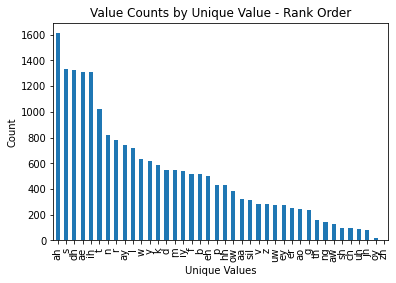

In [18]:
import matplotlib.pyplot as plt

# get the value counts and sort them in descending order
counts = phonemes_df['phoneme'].value_counts().sort_values(ascending=False)

# create a bar chart of the counts
fig, ax = plt.subplots()
counts.plot.bar(ax=ax)

# set the x-axis labels to the unique values
ax.set_xticklabels(counts.index)

# set the axis labels and title
ax.set_xlabel('Unique Values')
ax.set_ylabel('Count')
ax.set_title('Value Counts by Unique Value - Rank Order')

# display the plot
plt.show()

#### Analyse Original Predicted Phonemes

In [19]:
# textgrid_fname = "./dataset/wsDmwoOrpR8/The False Appeal of Communism.TextGrid"
textgrid_fname = "./dataset/NX2ep5fCJZ8/Jordan Peterson on the meaning of life for men MUST WATCH.TextGrid"
tg = TextGrid(textgrid_fname)

In [20]:
phones = tg["phones"]

In [21]:
phones

[<Interval text="" xmin=0.0 xmax=0.26>,
 <Interval text="W" xmin=0.26 xmax=0.35>,
 <Interval text="EH1" xmin=0.35 xmax=0.39>,
 <Interval text="L" xmin=0.39 xmax=0.44>,
 <Interval text="T" xmin=0.44 xmax=0.59>,
 <Interval text="EH1" xmin=0.59 xmax=0.65>,
 <Interval text="L" xmin=0.65 xmax=0.7>,
 <Interval text="Y" xmin=0.7 xmax=0.77>,
 <Interval text="UW1" xmin=0.77 xmax=0.82>,
 <Interval text="AH0" xmin=0.82 xmax=0.96>,
 <Interval text="K" xmin=0.96 xmax=0.97>,
 <Interval text="AH1" xmin=0.97 xmax=1.0>,
 <Interval text="P" xmin=1.0 xmax=1.03>,
 <Interval text="AH0" xmin=1.03 xmax=1.05>,
 <Interval text="L" xmin=1.05 xmax=1.08>,
 <Interval text="AH0" xmin=1.08 xmax=1.14>,
 <Interval text="V" xmin=1.14 xmax=1.22>,
 <Interval text="S" xmin=1.22 xmax=1.25>,
 <Interval text="T" xmin=1.25 xmax=1.3>,
 <Interval text="R" xmin=1.3 xmax=1.35>,
 <Interval text="EY1" xmin=1.35 xmax=1.45>,
 <Interval text="N" xmin=1.45 xmax=1.49>,
 <Interval text="JH" xmin=1.49 xmax=1.54>,
 <Interval text="TH" xmin

In [22]:
xmax  = np.array([p.xmax for p in phones])
xmin  = np.array([p.xmin for p in phones])
ph_s  = [p.text for p in phones]
ph_df = pd.DataFrame({"xmax": xmax, "xmin": xmin, "text": ph_s})

In [23]:
ph_df["duration"] = xmax - xmin

In [24]:
ph_df

xmax    xmin text  duration
0       0.260000    0.00       0.260000
1       0.350000    0.26    W  0.090000
2       0.390000    0.35  EH1  0.040000
3       0.440000    0.39    L  0.050000
4       0.590000    0.44    T  0.150000
...          ...     ...  ...       ...
7182  680.780000  680.64  IH1  0.140000
7183  680.850000  680.78    Z  0.070000
7184  681.700000  680.85    S  0.850000
7185  681.910000  681.70  OW1  0.210000
7186  684.431383  681.91       2.521383

[7187 rows x 4 columns]

### Visualise Mel Spectrogram

In [25]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_mel_spectrograms(pred, text):
    fig, ax = plt.subplots(1) # nrows=1, ncols=2)

    # ax[0].set_title(f"Mel Spectogram (Predicted)")
    pred = np.swapaxes(pred, 0, 1)
    cax = ax.imshow(pred, interpolation='nearest', cmap=cm.coolwarm, origin='lower')

    ax.set_title(text)
    
    return fig, ax

[]

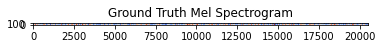

In [26]:
audio_feats = data["audio_feats"]
fig, ax = plot_mel_spectrograms(audio_feats, "Ground Truth Mel Spectrogram")
plt.plot()

## Model

### Linear Projection (Phoneme Classification / Mel Spectrogram Prediction)

In [27]:
import torch.nn as nn

class LipToPhoneModel(nn.Module):
    """Linear Projection from AV-HuBERT Embedding to Phone / Speech Features"""
    def __init__(self, ins, hidden, outs, dropout=0.5):
        super(LipToPhoneModel, self).__init__()

        print("Init start")

        self.fc1 = nn.Linear(ins, hidden)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden, outs)

        print("Init end")

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

### Linear Projection (Phoneme Classification) with Mel Spectrogram Prediction Auxilliary Learning Task

In [28]:
import torch.nn as nn

class LipToPhoneAuxillaryModel(nn.Module):
    """Linear Projection from AV-HuBERT Embedding to Phone and Speech Features"""
    def __init__(self, ins, hidden, main_outs, aux_outs, dropout=0.5):
        super(LipToPhoneAuxillaryModel, self).__init__()

        print("Init start")

        self.fc1 = nn.Linear(ins, hidden)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
        self.fc_main = nn.Linear(hidden, main_outs)
        self.fc_aux  = nn.Linear(hidden, aux_outs)

        print("Init end")

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        main = self.fc_main(x)
        aux  = self.fc_aux(x)

        return main, aux

## Trainset and Testset

### Set Random Seed

In [29]:
import numpy as np
import random
import torch
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

### All Possible Data

In [30]:
avhubert_feats = data["av_hubert"]
# avhubert_feats = data["av_hubert_large"]
phonemes       = data["phonemes"]
audio_feats    = data["audio_feats"]
# avhubert_feats.shape, phonemes.shape, audio_feats.shape
phonemes.shape, audio_feats.shape

((20506,), (20506, 128))

In [31]:
data["phonemes"].shape

(20506,)

### Define Input, Output

In [32]:
device = "cuda"

In [33]:
# x_s = landmarks_s_arr
x_s = avhubert_feats
y_s = phonemes
# y_s = audio_feats
y_aux_s = audio_feats

### Randomise Order (K-Folds Acc Doubled)

In [34]:
print(x_s.shape[0], y_s.shape[0])
seq_len = min(x_s.shape[0], y_s.shape[0])
x_s = x_s[:seq_len, :]
y_s = y_s[:seq_len]
y_aux_s = y_aux_s[:seq_len, :]
print(x_s.shape[0], y_s.shape[0], y_aux_s.shape[0])
assert x_s.shape[0] == y_s.shape[0]
random_idxs = np.random.permutation(x_s.shape[0])
x_s = x_s[random_idxs]
y_s = y_s[random_idxs]
y_aux_s = y_aux_s[random_idxs]

20533 20506
20506 20506 20506


In [35]:
x_s.shape, y_s.shape, y_aux_s.shape

(torch.Size([20506, 768]), (20506,), (20506, 128))

In [36]:
x_s.dtype

torch.float32

In [37]:
import torch
# CUDA_LAUNCH_BLOCKING=1
x_s = torch.tensor(x_s, dtype=torch.float).to(device)
# y_s = torch.tensor(y_s, dtype=torch.float).to("cuda")
y_s = torch.tensor(y_s, dtype=torch.long).to(device)
y_aux_s = torch.tensor(y_aux_s, dtype=torch.float).to("cuda")

/tmp/ipykernel_49154/4041233872.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_s = torch.tensor(x_s, dtype=torch.float).to(device)


In [38]:
# (seq_len, 98, 2) => (seq_len, 196)
x_s = x_s.view(x_s.shape[0], -1)

In [39]:
# Verify `x_s`` and `y_s` shape
x_s.shape, y_s.shape, y_aux_s.shape

(torch.Size([20506, 768]), torch.Size([20506]), torch.Size([20506, 128]))

In [40]:
dataset_ratio = 0.8
dataset_size  = min(x_s.shape[0], y_s.shape[0], y_aux_s.shape[0])
print(dataset_size)

20506


In [41]:
x_s = x_s[0:dataset_size, :]

In [42]:
train_x_s = x_s[0:int(dataset_size * dataset_ratio), :]
test_x_s  = x_s[int(dataset_size * dataset_ratio):,  :]

In [43]:
y_s = y_s[0:dataset_size]

In [44]:
train_y_s = y_s[0:int(dataset_size * dataset_ratio)]
test_y_s  = y_s[int(dataset_size * dataset_ratio):]

In [45]:
y_aux_s = y_aux_s[0:dataset_size, :]

In [46]:
train_y_aux_s = y_aux_s[0:int(dataset_size * dataset_ratio)]
test_y_aux_s  = y_aux_s[int(dataset_size * dataset_ratio):]

In [47]:
x_s.shape, y_s.shape, train_x_s.shape, train_y_s.shape, train_y_aux_s.shape, test_x_s.shape, test_y_s.shape, test_y_aux_s.shape

(torch.Size([20506, 768]),
 torch.Size([20506]),
 torch.Size([16404, 768]),
 torch.Size([16404]),
 torch.Size([16404, 128]),
 torch.Size([4102, 768]),
 torch.Size([4102]),
 torch.Size([4102, 128]))

In [48]:
y_s.shape

torch.Size([20506])

In [49]:
print(group_adjacent_duplicates(get_phone_list(y_s)))

NameError: name 'get_phone_list' is not defined

### BatchDim for Seq Models

In [50]:
# x_s = x_s.unsqueeze(0)
# y_s = y_s.unsqueeze(0)

In [51]:
print("FINAL SHAPES:")
x_s.shape, y_s.shape, y_aux_s.shape

FINAL SHAPES:


(torch.Size([20506, 768]), torch.Size([20506]), torch.Size([20506, 128]))

In [142]:
y_s.shape[-1]

20506

## Train (Overfit) - Phoneme Classification (SKLearn)

In [143]:
x_s.shape, y_s.shape

(torch.Size([20506, 768]), torch.Size([20506]))

In [52]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

svm_x_s = x_s.cpu().detach()
svm_y_s = y_s.cpu().detach()

clf_s = ["svm" ] # , "random_forest", "neural_network"]
for clf_n in clf_s:
    if clf_n == "svm":
        clf = svm.SVC(kernel='linear')
    elif clf_n == "random_forest":
        clf = RandomForestClassifier(n_estimators=100)
    elif clf_n == "neural_network":
        clf = MLPClassifier(max_iter=100)

    clf.fit(svm_x_s, svm_y_s)
    y_pred = clf.predict(svm_x_s)
    accuracy = accuracy_score(svm_y_s, y_pred)
    print("Classifier", clf_n, "Accuracy:", accuracy)

Classifier svm Accuracy: 0.9501609285087291


In [53]:
svm_x_s.shape, svm_y_s.shape

(torch.Size([20506, 768]), torch.Size([20506]))

In [54]:
svm_y_s[0:20], y_pred[0:20]

(tensor([14, 36, 24, 10,  0, 12, 13,  0, 37, 13, 23, 13, 35, 39,  4,  2, 11, 32,
         38,  2]),
 array([14, 36, 24, 10,  0, 12, 13,  0, 37, 13, 23, 13, 35, 39,  4, 36, 11,
        32, 38,  2]))

In [55]:
single_svm_x_s = svm_x_s[0]
single_svm_y_s = svm_y_s[0].item()
single_svm_x_s.shape, single_svm_y_s

(torch.Size([768]), 14)

In [56]:
single_svm_x_s = single_svm_x_s.unsqueeze(0)
single_svm_x_s.shape

torch.Size([1, 768])

In [57]:
single_y_pred = clf.predict(single_svm_x_s)
single_y_pred

array([14])

## Train (Generalise) - Phoneme Classification (SKLearn + K-Folds)

In [58]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

kernels = ["linear"] # , "poly", "rbf", "sigmoid"]

svm_train_x_s = train_x_s.cpu().detach()
svm_train_y_s = train_y_s.cpu().detach()
svm_test_x_s = test_x_s.cpu().detach()
svm_test_y_s = test_y_s.cpu().detach()


def run_kfolds(model, x, y, splits):
    kf = KFold(n_splits=splits, shuffle=True)
    scores = cross_val_score(model, x, y, cv=kf, scoring="accuracy")
    return scores

# clf_s = ["svm", "random_forest", "neural_network"]
# clf_s = ["neural_network"]
clf_s = ["svm"]
for clf_n in clf_s:
    if clf_n == "svm":
        clf = svm.SVC(kernel='linear')
    if clf_n == "svm":
        for kernel in kernels:
            clf = svm.SVC(kernel=kernel)
            # clf.fit(svm_train_x_s, svm_train_y_s)
            # svm_y_pred = clf.predict(svm_test_x_s)
            # accuracy = accuracy_score(svm_test_y_s, svm_y_pred)
            scores = run_kfolds(clf, svm_x_s, svm_y_s, splits=5)
            print(
                "Classifier", clf_n,
                "Kernel:", kernel,
                "Scores:", scores,
                "Scores(mean):", scores.mean())
    elif clf_n == "random_forest":
        clf = RandomForestClassifier(n_estimators=100)
        #clf.fit(svm_train_x_s, svm_train_y_s)
        #svm_y_pred = clf.predict(svm_test_x_s)
        #accuracy = accuracy_score(svm_test_y_s, svm_y_pred)
        scores = run_kfolds(clf, svm_x_s, svm_y_s, splits=5)
        print(
            "Classifier", clf_n,
            "Kernel:", kernel,
            "Scores:", scores,
            "Scores(mean):", scores.mean())
    elif clf_n == "neural_network":
        clf = MLPClassifier(hidden_layer_sizes=(512), max_iter=200)
        # clf.fit(svm_train_x_s, svm_train_y_s)
        # svm_y_pred = clf.predict(svm_test_x_s)
        # accuracy = accuracy_score(svm_test_y_s, svm_y_pred)
        scores = run_kfolds(clf, svm_x_s, svm_y_s, splits=5)
        print(
            "Classifier", clf_n,
            "Kernel:", kernel,
            "Scores:", scores,
            "Scores(mean):", scores.mean())

Classifier svm Kernel: linear Scores: [0.65480254 0.65520605 0.64203853 0.63740551 0.65301146] Scores(mean): 0.6484928162626018


## Train (Overfit) - Mel Spectrogram (Neural Network)

In [350]:
from torch.cuda.amp        import autocast, GradScaler
import matplotlib.pyplot   as plt
import torch.nn.functional as F
import torch

print("device:", device)
print("x_s.device:", x_s.device)

amp = True

model = LipToPhoneModel(
    x_s.shape[-1],
    512,
    y_s.shape[-1]).to(device)

print("y_s.shape[-1] original:", y_s.shape[-1])
epochs = 10000
lr = 1e-3

# optim = torch.optim.AdamW(params=model.parameters(), lr=lr)
optim = torch.optim.Adam(params=model.parameters(), lr=lr)

losses_s = []

scaler = GradScaler()
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min')
# scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=2000, gamma=0.1)

pred_s = []

criteria = nn.MSELoss()

model.train()
for epoch_idx in range(epochs):
    with autocast(
        enabled=True,
        dtype=torch.bfloat16):

        pred = model(x_s)

        assert pred.shape[0] == y_s.shape[0]
        cur_pred = pred
        cur_y    = y_s
        #pred_phones = cur_pred.argmax(-1)
        #y_phones = cur_y
        # print("cur_pred.shape, cur_y.shape:", cur_pred.shape, cur_y.shape)
        loss = criteria(cur_pred, cur_y)
        
        if epoch_idx % 1000 == 0:
            # test
            model.eval()
            with torch.no_grad():
                test_pred = model(x_s)
                test_loss = criteria(test_pred, y_s)
                #test_pred_phones = test_pred.argmax(-1)
                #test_y_phones = y_s
                #correct_phones = (test_pred_phones == test_y_phones).sum().item()
                #acc = correct_phones / test_pred_phones.shape[-1]
            print(
                epoch_idx,
                loss.item(),
                test_loss.item(),
                optim.param_groups[0]['lr'],
                #test_pred_phones,
            )
                # f"{acc:.2%}",
                # "\n",
                # print_phone_list(test_pred_phones),
                # "\n",
                # print_phone_list(test_y_phones),
                # "\n")
            
            model.train()
        

        # print(pred, y)
        losses_s.append(loss.detach().item())

    #loss.backward()
    #optim.step()

    scaler.scale(loss).backward()
    scaler.step(optim)
    scaler.update()
    
    # scheduler.step(loss)


plt.plot(losses_s)

device: cuda
x_s.device: cuda:0
Init start
Init end
y_s.shape[-1] original: 1232


RuntimeError: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility

### Visualise Mel Spectrogram

In [153]:
from matplotlib import cm

def plot_mel_spectrogram(mel_spec, title):
    fig, ax = plt.subplots(1)

    ax.set_title(f"Mel Spectrogram \"{title}\"")
    pred = np.swapaxes(mel_spec, 0, 1)
    cax = ax.imshow(pred, interpolation='nearest', cmap=cm.coolwarm, origin='lower')

    return fig

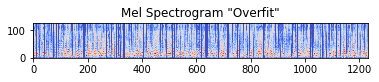

In [154]:
_ = plot_mel_spectrogram(cur_pred.cpu().detach().float(), "Overfit")

## Train (Generalise) - Mel Spectrogram (Neural Network)

device: cuda
x_s.device: cuda:0
Init start
Init end
y_s.shape[-1] original: 128
0 48.19505310058594 47.399009704589844 0.0001
1000 3.5627055168151855 5.870646953582764 0.0001
2000 2.0417182445526123 5.154745578765869 0.0001
3000 1.3072969913482666 5.174712657928467 1e-05
4000 1.244376301765442 5.197429656982422 1e-05
5000 1.166894555091858 5.22865629196167 1e-05
6000 1.0777584314346313 5.272486686706543 1.0000000000000002e-06
7000 1.0674446821212769 5.277418613433838 1.0000000000000002e-06
8000 1.055605173110962 5.284145355224609 1.0000000000000002e-06
9000 1.0425236225128174 5.290445327758789 1.0000000000000002e-07


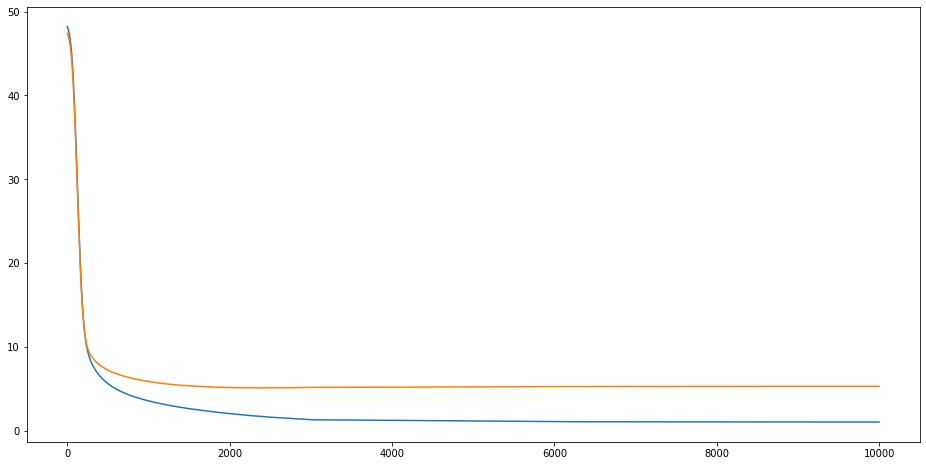

In [165]:
from torch.cuda.amp        import autocast, GradScaler
import matplotlib.pyplot   as plt
import torch.nn.functional as F
import torch

print("device:", device)
print("x_s.device:", x_s.device)

amp = True

model = LipToPhoneModel(
    train_x_s.shape[-1],
    256,
    train_y_s.shape[-1]).to(device)

print("y_s.shape[-1] original:", y_s.shape[-1])
epochs = 10_000
lr = 1e-4

# optim = torch.optim.AdamW(params=model.parameters(), lr=lr)
optim = torch.optim.Adam(params=model.parameters(), lr=lr)

losses_s = []
vlosses_s = []
scaler = GradScaler()
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min')
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=3000, gamma=0.1)

pred_s = []

criteria = nn.MSELoss()

model.train()
for epoch_idx in range(epochs):
    with autocast(
        enabled=True,
        dtype=torch.bfloat16):

        pred = model(train_x_s)

        # print("pred.shape[0], train_y_s.shape[0]:", pred.shape, train_y_s.shape)
        assert pred.shape[0] == train_y_s.shape[0]
        cur_pred = pred
        cur_y    = train_y_s
        #pred_phones = cur_pred.argmax(-1)
        #y_phones = cur_y
        # print("cur_pred.shape, cur_y.shape:", cur_pred.shape, cur_y.shape)
        loss = criteria(cur_pred, cur_y)
        
        
        # test
        model.eval()
        with torch.no_grad():
            test_pred = model(test_x_s)
            test_loss = criteria(test_pred, test_y_s)
            vlosses_s.append(test_loss.detach().item())
            #test_pred_phones = test_pred.argmax(-1)
            #test_y_phones = y_s
            #correct_phones = (test_pred_phones == test_y_phones).sum().item()
            #acc = correct_phones / test_pred_phones.shape[-1]
        if epoch_idx % 1000 == 0:
            print(
                epoch_idx,
                loss.item(),
                test_loss.item(),
                optim.param_groups[0]['lr'],
                #test_pred_phones,
            )
                # f"{acc:.2%}",
                # "\n",
                # print_phone_list(test_pred_phones),
                # "\n",
                # print_phone_list(test_y_phones),
                # "\n")
            
        model.train()
        

        # print(pred, y)
        losses_s.append(loss.detach().item())

    #loss.backward()
    #optim.step()

    scaler.scale(loss).backward()
    scaler.step(optim)
    scaler.update()
    
    scheduler.step()

plt.plot(losses_s)
plt.plot(vlosses_s)

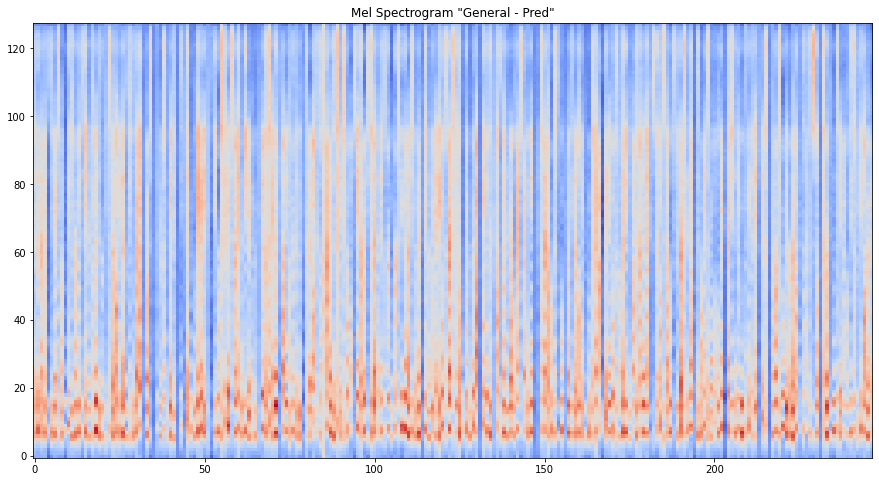

In [166]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,8)
_ = plot_mel_spectrogram(test_pred.cpu().detach().float(), "General - Pred")

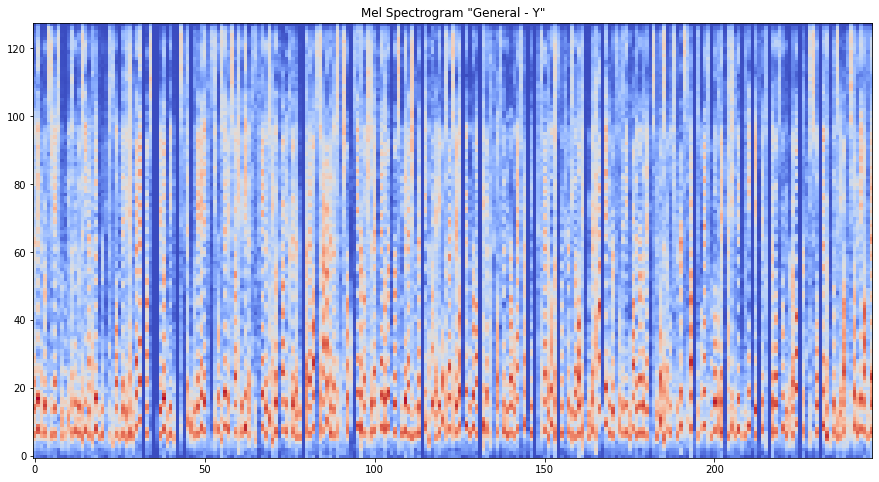

In [167]:
_ = plot_mel_spectrogram(test_y_s.cpu().detach().float(), "General - Y")

## Train (Overfit) - Phone (Neural Network)

In [59]:
def get_phone_list(phones):
    d = [dataset.phoneme_dict[int(ph_id)]
        if ph_id < len(dataset.phoneme_dict)
        else -1
        for ph_id in phones]
    return d

In [60]:
def print_phone_list(phones):
    d = [dataset.phoneme_dict[int(ph_id)]
        if ph_id < len(dataset.phoneme_dict)
        else -1
        for ph_id in phones]
    print(d)

device: cuda
x_s.device: cuda:0
Init start
Init end
y_s.shape[-1] original: 20506
['uh', 't', 'er', 't', 'hh', 'ch', 'er', 't', 'er', 'er', 'er', 'y', 'er', 'b', 'b', 't', 'th', 'er', 'b', 'er', 'er', 'b', 'er', 'oy', 'er', 'er', 's', 'er', 'aa', 'b', 'er', 'er', 'er', 'er', 't', 'er', 'er', 't', 'y', 'er', 'er', 's', 'er', 'er', 'er', 'b', 'y', 'ay', 'b', 'ey', 'er', 'er', 't', 't', 't', 'er', 't', 'g', 't', 'aa', 'sil', 't', 'y', 't', 'oy', 'ae', 'y', 'b', 'ey', 'oy', 'ch', 'b', 'er', 'th', 't', 'er', 't', 'ay', 't', 'ay', 'ey', 's', 'b', 'oy', 'ey', 'er', 'b', 'oy', 'er', 'ay', 'ey', 'b', 'th', 'er', 'aa', 'ey', 'th', 'er', 'ey', 'y', 'ow', 'er', 'oy', 't', 't', 'er', 'er', 's', 't', 't', 'er', 'y', 'b', 'b', 's', 'er', 'er', 'ey', 'ey', 'b', 't', 'b', 'er', 'ow', 'aa', 'ow', 'w', 'b', 'iy', 'g', 'ey', 'k', 'b', 'b', 'uh', 'th', 'b', 'er', 'er', 't', 'k', 'oy', 'b', 'er', 'er', 'y', 't', 'aa', 'oy', 't', 'er', 'oy', 'oy', 'er', 'er', 'er', 'b', 'oy', 'oy', 't', 'ay', 'er', 'k', 'b',

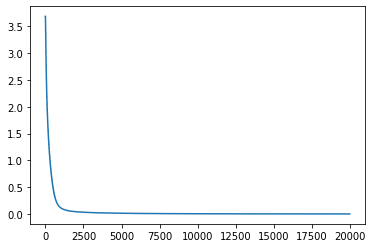

In [61]:
from torch.cuda.amp        import autocast, GradScaler
import matplotlib.pyplot   as plt
import torch.nn.functional as F
import torch

print("device:", device)
print("x_s.device:", x_s.device)

amp = True

model = LipToPhoneModel(
    x_s.shape[-1],
    256,
    len(dataset.phoneme_dict)).to(device)

print("y_s.shape[-1] original:", y_s.shape[-1])
epochs = 10000
lr = 1e-3

# optim = torch.optim.AdamW(params=model.parameters(), lr=lr)
optim = torch.optim.Adam(params=model.parameters(), lr=lr)

losses_s = []

scaler = GradScaler()
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min')
# scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=2000, gamma=0.1)

pred_s = []

criteria = nn.CrossEntropyLoss()

model.train()
for epoch_idx in range(epochs):
    with autocast(
        enabled=True,
        dtype=torch.bfloat16):

        # print("pre model x_s.shape:", x_s.shape)
        pred = model(x_s)
        pred = F.log_softmax(pred, -1)
        pred_phones = pred.argmax(-1)
        y_phones = y_s
        # pred_code = dataset.decode(pred[0])

        assert pred.shape[0] == y_s.shape[0]
        # loss_iter = 1 # pred.shape[0]
        #losses = []
        #correct_phones = 0
        #total_len = 0

        #print("loss_iter:", loss_iter)
        #print("y_s.shape:", y_s.shape)
        # for iter in range(loss_iter):
            #print("pred.shape, y_s.shape:", pred.shape, y_s.shape)
        cur_pred = pred
        cur_y    = y_s
        pred_phones = cur_pred.argmax(-1)
        y_phones = cur_y
        #print("cur_pred.shape, cur_y.shape:", cur_pred.shape, cur_y.shape)
        #print("cur_pred.dtype, cur_y.dtype:", cur_pred.dtype, cur_y.dtype)
        loss = criteria(cur_pred, cur_y)
        #losses.append(loss)
        losses_s.append(loss.item())
        correct_phones = (pred_phones == y_phones).sum().item()
        # print("pred_phones.shape, y_phones.shape:", pred_phones.shape, y_phones.shape)
        # print("correct_phones:", correct_phones, y_phones, y_phones.shape)
        #total_len += y_phones.size(0)
        #loss = sum(losses) / loss_iter

        # print(
        #     "pred.shape, y_s.shape:",
        #     pred.shape,
        #     y_s.shape,
        #     pred_phones,
        #     y_s)
        
            # print_phone_list(pred_phones),
            # print_phone_list(y_s))
        

        #loss = criteria(pred, y_s)
        # loss = F.mse_loss(pred, y_s)
        
        if epoch_idx % 1000 == 0:
            # test
            model.eval()
            with torch.no_grad():
                test_pred = model(x_s)
                test_loss = criteria(test_pred, y_s)
                test_pred_phones = test_pred.argmax(-1)
                test_y_phones = y_s
                correct_phones = (test_pred_phones == test_y_phones).sum().item()
                #print("test_pred.shape, test_pred_phones.shape:", test_pred.shape, test_pred_phones.shape)
                #print("test_pred_phones, test_y_phones", test_pred_phones, test_y_phones)
                acc = correct_phones / test_pred_phones.shape[-1]
            print(
                epoch_idx,
                loss.item(),
                test_loss.item(),
                optim.param_groups[0]['lr'],
                #test_pred_phones,
                f"{acc:.2%}",
                "\n",
                print_phone_list(test_pred_phones),
                "\n",
                print_phone_list(test_y_phones),
                "\n")
            
            model.train()
        

        # print(pred, y)
        losses_s.append(loss.detach().item())

    #loss.backward()
    #optim.step()

    scaler.scale(loss).backward()
    scaler.step(optim)
    scaler.update()
    
    # scheduler.step(loss)


plt.plot(losses_s)

## Train (Generalise) - Phone (Neural Network)

device: cuda
train_x_s.device: cuda:0
Init start
Init end
y_s.shape[-1] original: 16404
['uh', 'dh', 'm', 'm', 'dh', 'ow', 'uw', 'ow', 'dh', 'k', 'm', 'dh', 'er', 'dh', 'ng', 'dh', 'p', 'm', 'dh', 'uw', 'dh', 'l', 'dh', 'dh', 'dh', 'dh', 'ey', 'p', 'dh', 'dh', 'dh', 'dh', 'ng', 'dh', 'dh', 'hh', 'ng', 'ey', 'dh', 'uw', 'aw', 'p', 'dh', 'dh', 'dh', 'dh', 'dh', 'dh', 'dh', 'dh', 'dh', 'uw', 'ng', 'dh', 'ow', 'dh', 'ng', 'dh', 'uw', 'w', 'd', 'm', 'dh', 'dh', 'ey', 'ng', 'd', 'dh', 'p', 'ng', 'm', 'dh', 'm', 't', 'dh', 'dh', 'sil', 'dh', 'dh', 'ng', 'p', 'dh', 'p', 's', 'ey', 'ey', 'p', 'dh', 'dh', 's', 'eh', 'uw', 'ng', 'ng', 'dh', 'ah', 'ng', 'ey', 'dh', 'w', 'ah', 's', 'ah', 'dh', 'dh', 'p', 'ey', 'ah', 'd', 'ng', 'g', 'dh', 'dh', 'uw', 'uw', 'd', 'k', 'dh', 'p', 'er', 'd', 'p', 'm', 'ng', 'uw', 'dh', 'ng', 'dh', 'aa', 'ey', 'ng', 'dh', 'dh', 'p', 'ng', 'l', 'b', 'ng', 'dh', 'dh', 'p', 'ey', 'dh', 'ah', 'dh', 'y', 'dh', 'ng', 'dh', 'dh', 'sil', 's', 'ey', 'dh', 'm', 'p', 'p', 'ow', 'dh

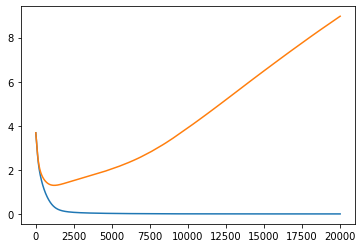

Text(0.5, 1.0, 'Peak Acc: 100.00%, Peak VAcc: 66.72%')

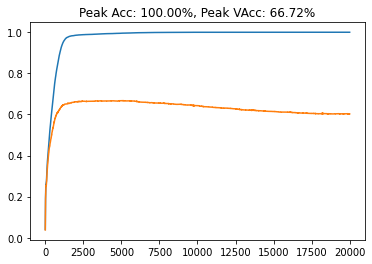

In [76]:
from torch.cuda.amp        import autocast, GradScaler
import matplotlib.pyplot   as plt
import torch.nn.functional as F
import torch

print("device:", device)
print("train_x_s.device:", train_x_s.device)

amp = True

model = LipToPhoneModel(
    train_x_s.shape[-1],
    1024,
    len(dataset.phoneme_dict),
    dropout=0.5).to(device)

print("y_s.shape[-1] original:", train_y_s.shape[-1])
epochs = 20_000
lr = 1e-4 # 5e-5

# optim = torch.optim.AdamW(params=model.parameters(), lr=lr)
optim = torch.optim.AdamW(params=model.parameters(), lr=lr)

losses_s = []
vlosses_s = []

scaler = GradScaler()
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min')
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=epochs, gamma=0.1)

pred_s = []

acc_s = []
vacc_s = []
criteria = nn.CrossEntropyLoss()

model.train()
for epoch_idx in range(epochs):
    with autocast(
        enabled=False,
        dtype=torch.bfloat16):

        # print("pre model x_s.shape:", x_s.shape)
        pred = model(train_x_s)
        pred = F.log_softmax(pred, -1)
        pred_phones = pred.argmax(-1)
        y_phones = train_y_s
        # pred_code = dataset.decode(pred[0])

        assert pred.shape[0] == train_y_s.shape[0]
        # loss_iter = 1 # pred.shape[0]
        #losses = []
        #correct_phones = 0
        #total_len = 0

        #print("loss_iter:", loss_iter)
        #print("y_s.shape:", y_s.shape)
        # for iter in range(loss_iter):
            #print("pred.shape, y_s.shape:", pred.shape, y_s.shape)
        cur_pred = pred
        cur_y    = train_y_s
        pred_phones = cur_pred.argmax(-1)
        y_phones = cur_y
        #print("cur_pred.shape, cur_y.shape:", cur_pred.shape, cur_y.shape)
        #print("cur_pred.dtype, cur_y.dtype:", cur_pred.dtype, cur_y.dtype)
        loss = criteria(cur_pred, cur_y)
        #losses.append(loss)
        losses_s.append(loss.item())
        correct_phones = (pred_phones == y_phones).sum().item()
        acc = correct_phones / pred_phones.shape[-1]
        acc_s.append(acc)
        # print("pred_phones.shape, y_phones.shape:", pred_phones.shape, y_phones.shape)
        # print("correct_phones:", correct_phones, y_phones, y_phones.shape)
        #total_len += y_phones.size(0)
        #loss = sum(losses) / loss_iter

        # print(
        #     "pred.shape, y_s.shape:",
        #     pred.shape,
        #     y_s.shape,
        #     pred_phones,
        #     y_s)
        
            # print_phone_list(pred_phones),
            # print_phone_list(y_s))
        

        #loss = criteria(pred, y_s)
        # loss = F.mse_loss(pred, y_s)
        
        
        # test
        model.eval()
        with torch.no_grad():
            test_pred = model(test_x_s)
            test_loss = criteria(test_pred, test_y_s)
            test_pred_phones = test_pred.argmax(-1)
            test_y_phones = test_y_s
            correct_phones = (test_pred_phones == test_y_phones).sum().item()
            #print("test_pred.shape, test_pred_phones.shape:", test_pred.shape, test_pred_phones.shape)
            #print("test_pred_phones, test_y_phones", test_pred_phones, test_y_phones)
            vacc = correct_phones / test_pred_phones.shape[-1]
            vacc_s.append(vacc)
            vlosses_s.append(test_loss.detach().item())

        if epoch_idx % 1000 == 0:
            print(
                epoch_idx,
                loss.item(),
                test_loss.item(),
                optim.param_groups[0]['lr'],
                #test_pred_phones,
                f"{vacc:.2%}",
                "\n",
                print_phone_list(test_pred_phones),
                "\n",
                print_phone_list(test_y_phones),
                "\n")
            
        model.train()
        
        # print(pred, y)
        # losses_s.append(loss.detach().item())

    #loss.backward()
    #optim.step()

    scaler.scale(loss).backward()
    scaler.step(optim)
    scaler.update()
    
    # scheduler.step(test_loss)
    scheduler.step()

plt.plot(losses_s)
plt.plot(vlosses_s)
plt.show()
plt.plot(acc_s)
plt.plot(vacc_s)
plt.title(f"Peak Acc: {max(acc_s):.2%}, Peak VAcc: {max(vacc_s):.2%}")

### Test Set Phoneme Distribution

In [77]:
print_phone_list(test_y_s)
#test_y_ph_lst = get_phone_list(test_y_phones.cpu())
## test_y_ph_lst = group_adjacent_duplicates(test_y_ph_lst)
#print(test_y_ph_lst)

['ae', 'ih', 'y', 'ay', 'ah', 's', 'd', 'f', 'ae', 's', 'ih', 'ah', 'iy', 'b', 'hh', 'ae', 'aw', 'l', 'd', 'sh', 'eh', 'd', 'y', 'w', 'ae', 'sh', 'f', 's', 'r', 'd', 'aa', 'n', 'r', 'y', 'w', 's', 'ah', 'f', 'ah', 'ah', 'l', 'ih', 'n', 'p', 'l', 'ih', 'l', 'ey', 'k', 'ah', 'w', 'ow', 'd', 'ey', 'aa', 'd', 'r', 'jh', 't', 'f', 'v', 't', 'ih', 'dh', 'k', 't', 't', 'ae', 'ey', 'ow', 'y', 'b', 'f', 'n', 'dh', 'th', 'eh', 'eh', 'uw', 'r', 'th', 's', 'ah', 'b', 'uw', 's', 'ah', 'dh', 'r', 'r', 'l', 'ae', 'dh', 's', 'v', 'r', 'ae', 'uw', 'r', 'ih', 'sh', 'aa', 'ah', 'y', 'z', 'ow', 'ao', 'ae', 'z', 'ih', 'ah', 'p', 'ah', 'ah', 'er', 'w', 'dh', 'k', 'y', 'aa', 'v', 'z', 's', 'l', 't', 't', 'sil', 'p', 'hh', 'ih', 'f', 'ae', 'b', 'er', 'uw', 'g', 'l', 'hh', 'ah', 'iy', 'm', 'sil', 'ah', 'l', 'r', 't', 'k', 't', 'er', 'ae', 'b', 'ay', 'ae', 'ah', 'w', 'aw', 'y', 'ah', 'n', 'l', 'f', 'ay', 'ih', 's', 't', 'b', 'w', 'ah', 'ay', 'ih', 'uw', 'jh', 'ae', 'ih', 'p', 'r', 'hh', 'ay', 't', 'r', 'hh', 'r

(4102, 1)


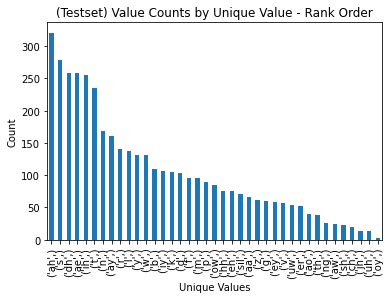

In [78]:
import matplotlib.pyplot as plt

test_y_df = pd.DataFrame(columns=["phoneme"], data=[dataset.phoneme_dict[d]
                                                    for d in test_y_phones.cpu()])

# get the value counts and sort them in descending order
counts = test_y_df.value_counts().sort_values(ascending=False)

# create a bar chart of the counts
fig, ax = plt.subplots()
counts.plot.bar(ax=ax)

# set the x-axis labels to the unique values
ax.set_xticklabels(counts.index)

# set the axis labels and title
ax.set_xlabel('Unique Values')
ax.set_ylabel('Count')
ax.set_title('(Testset) Value Counts by Unique Value - Rank Order')

# display the plot
print(test_y_df.shape)
plt.show()

### Phoneme Prediction Confusion Matrix

In [79]:
cm_pred = test_pred_phones.cpu()

In [80]:
cm_y = test_y_phones.cpu()

In [81]:
cm_y

tensor([12,  2, 10,  ..., 11,  9, 10])

In [82]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(cm_y, cm_pred)

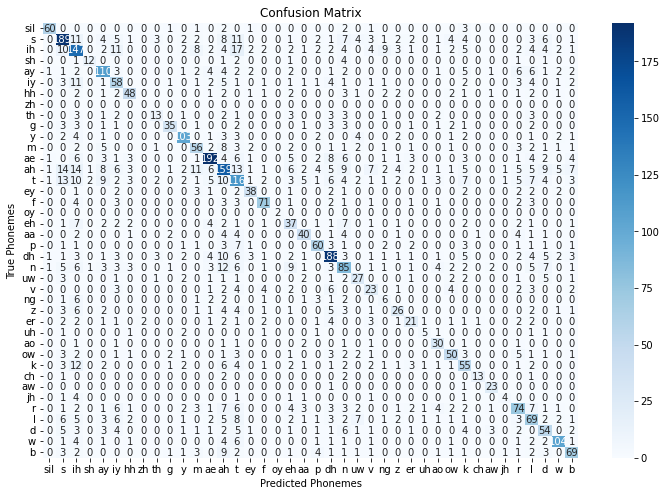

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# labels = np.unique(cm_y)
# phone_dict_idxs = list(range(len(dataset.phoneme_dict)))
labels = np.unique(torch.concat((cm_y, cm_pred), dim=0))

labels = [dataset.phoneme_dict[ph] for ph in labels]

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)

# Set labels and title
plt.xlabel('Predicted Phonemes')
plt.ylabel('True Phonemes')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [70]:
cm

array([[ 57,   0,   1, ...,   0,   0,   0],
       [  1, 186,   9, ...,   8,   0,   1],
       [  0,   8, 142, ...,   3,   3,   2],
       ...,
       [  0,   6,   5, ...,  53,   0,   1],
       [  0,   0,   1, ...,   1, 109,   1],
       [  0,   1,   1, ...,   3,   0,  69]])

In [71]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Extracting true negatives, false positives, false negatives, true positives
# tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]

# Compute evaluation metrics
accuracy   = accuracy_score(cm_y, cm_pred)
precision  = precision_score(cm_y, cm_pred, average="micro")
recall     = recall_score(cm_y, cm_pred, average="micro")
f1         = f1_score(cm_y, cm_pred, average="micro")

# Print confusion matrix and evaluation metrics
print("Confusion Matrix:")
print(cm)
# print("True Negatives:", tn)
# print("False Positives:", fp)
# print("False Negatives:", fn)
# print("True Positives:", tp)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Confusion Matrix:
[[ 57   0   1 ...   0   0   0]
 [  1 186   9 ...   8   0   1]
 [  0   8 142 ...   3   3   2]
 ...
 [  0   6   5 ...  53   0   1]
 [  0   0   1 ...   1 109   1]
 [  0   1   1 ...   3   0  69]]
Accuracy: 0.5958069234519746
Precision: 0.5958069234519746
Recall: 0.5958069234519746
F1 Score: 0.5958069234519746


## Train (Overfit) - Phone (Neural Network + Aux Tas)

In [72]:
from torch.cuda.amp        import autocast, GradScaler
import matplotlib.pyplot   as plt
import torch.nn.functional as F
import torch

print("device:", device)
print("x_s.device:", x_s.device)

amp = True

model = LipToPhoneAuxillaryModel(
    x_s.shape[-1],
    256,
    len(dataset.phoneme_dict),
    y_aux_s.shape[-1]).to(device)

print("y_s.shape[-1] original:", y_s.shape[-1])
epochs = 10000
lr = 1e-3

# optim = torch.optim.AdamW(params=model.parameters(), lr=lr)
optim = torch.optim.AdamW(params=model.parameters(), lr=lr)

losses_s = []

scaler = GradScaler()
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min')
# scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=2000, gamma=0.1)

pred_s = []

criteria = nn.CrossEntropyLoss()
aux_criteria = nn.MSELoss()
aux_lambda = 0.1 # weight the auxilliary learning task much smaller

model.train()
for epoch_idx in range(epochs):
    with autocast(
        enabled=True,
        dtype=torch.bfloat16):

        # print("pre model x_s.shape:", x_s.shape)
        pred, aux_pred = model(x_s)
        pred = F.log_softmax(pred, -1)
        pred_phones = pred.argmax(-1)
        y_phones = y_s
        # pred_code = dataset.decode(pred[0])

        assert pred.shape[0] == y_s.shape[0]
        assert aux_pred.shape[0] == y_aux_s.shape[0]
        # loss_iter = 1 # pred.shape[0]
        #losses = []
        #correct_phones = 0
        #total_len = 0

        #print("loss_iter:", loss_iter)
        #print("y_s.shape:", y_s.shape)
        # for iter in range(loss_iter):
            #print("pred.shape, y_s.shape:", pred.shape, y_s.shape)
        cur_pred = pred
        cur_y    = y_s
        pred_phones = cur_pred.argmax(-1)
        y_phones = cur_y
        #print("cur_pred.shape, cur_y.shape:", cur_pred.shape, cur_y.shape)
        #print("cur_pred.dtype, cur_y.dtype:", cur_pred.dtype, cur_y.dtype)
        
        loss = criteria(cur_pred, cur_y) + aux_criteria(aux_pred, y_aux_s)

        #losses.append(loss)
        losses_s.append(loss.item())
        correct_phones = (pred_phones == y_phones).sum().item()
        # print("pred_phones.shape, y_phones.shape:", pred_phones.shape, y_phones.shape)
        # print("correct_phones:", correct_phones, y_phones, y_phones.shape)
        #total_len += y_phones.size(0)
        #loss = sum(losses) / loss_iter

        # print(
        #     "pred.shape, y_s.shape:",
        #     pred.shape,
        #     y_s.shape,
        #     pred_phones,
        #     y_s)
        
            # print_phone_list(pred_phones),
            # print_phone_list(y_s))
        

        #loss = criteria(pred, y_s)
        # loss = F.mse_loss(pred, y_s)
        
        if epoch_idx % 1000 == 0:
            # test
            model.eval()
            with torch.no_grad():
                test_pred, test_aux = model(x_s)
                test_loss = criteria(test_pred, y_s) + aux_criteria(test_aux, y_aux_s)
                test_pred_phones = test_pred.argmax(-1)
                test_y_phones = y_s
                correct_phones = (test_pred_phones == test_y_phones).sum().item()
                #print("test_pred.shape, test_pred_phones.shape:", test_pred.shape, test_pred_phones.shape)
                #print("test_pred_phones, test_y_phones", test_pred_phones, test_y_phones)
                acc = correct_phones / test_pred_phones.shape[-1]
            print(
                epoch_idx,
                loss.item(),
                test_loss.item(),
                optim.param_groups[0]['lr'],
                #test_pred_phones,
                f"{acc:.2%}",
                "\n",
                print_phone_list(test_pred_phones),
                "\n",
                print_phone_list(test_y_phones),
                "\n")
            
            model.train()
        

        # print(pred, y)
        losses_s.append(loss.detach().item())

    #loss.backward()
    #optim.step()

    scaler.scale(loss).backward()
    scaler.step(optim)
    scaler.update()
    
    # scheduler.step(loss)


plt.plot(losses_s)

device: cuda
x_s.device: cuda:0
Init start
Init end
y_s.shape[-1] original: 20506
['ih', 'ey', 'ih', 'ih', 'ih', 'ng', 'ih', 'ih', 'ih', 'y', 'ih', 'ih', 'ih', 'ih', 'y', 'ih', 'ih', 'ih', 'ih', 'ih', 'er', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'p', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'th', 'ey', 'ih', 'ih', 'ih', 'ih', 'ey', 'ih', 'm', 'ih', 'ih', 'ih', 'y', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'f', 'ih', 'ih', 'f', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'th', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'uh', 'uh', 'th', 'ng', 't', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'uh', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'uh', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'ey', 'ih', 'ih', 'uh', 'ih', 'ih', 'th', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'ih', 'r', 'uh', 'ih', 'ih', 'uh', 'ih', 'ih', 'ih', 'ih', 'ih', 'y', 'r', 'ih', 'ey', 'ih', 'ih', 'ih', 'ih', 'ih', 'b', 'ih', 'r', 'd', 'uh', 'ih', 'ey', 'ih', 'ih', '

KeyboardInterrupt: 

## Train (Generalise) - Phone (Neural Network + Aux Tas)

In [ ]:
from torch.cuda.amp        import autocast, GradScaler
import matplotlib.pyplot   as plt
import torch.nn.functional as F
import torch

print("device:", device)
print("x_s.device:", x_s.device)

amp = True

model = LipToPhoneAuxillaryModel(
    x_s.shape[-1],
    256,
    len(dataset.phoneme_dict),
    y_aux_s.shape[-1]).to(device)

print("y_s.shape[-1] original:", y_s.shape[-1])
epochs = 20000
lr = 1e-4

# optim = torch.optim.AdamW(params=model.parameters(), lr=lr)
optim = torch.optim.AdamW(params=model.parameters(), lr=lr)

losses_s = []
vlosses_s = []

scaler = GradScaler()
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min')
# scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=2000, gamma=0.1)

pred_s = []

acc_s = []
vacc_s = []

criteria = nn.CrossEntropyLoss()
aux_criteria = nn.L1Loss() # (Mean Absolute Error)
aux_lambda = 0.0 # weight the auxilliary learning task much smaller

model.train()
for epoch_idx in range(epochs):
    with autocast(
        enabled=True,
        dtype=torch.bfloat16):

        # print("pre model x_s.shape:", x_s.shape)
        pred, aux_pred = model(train_x_s)
        pred = F.log_softmax(pred, -1)
        pred_phones = pred.argmax(-1)
        y_phones = train_y_s
        # pred_code = dataset.decode(pred[0])

        assert pred.shape[0] == train_y_s.shape[0]
        assert aux_pred.shape[0] == train_y_aux_s.shape[0]
        # loss_iter = 1 # pred.shape[0]
        #losses = []
        #correct_phones = 0
        #total_len = 0

        #print("loss_iter:", loss_iter)
        #print("y_s.shape:", y_s.shape)
        # for iter in range(loss_iter):
            #print("pred.shape, y_s.shape:", pred.shape, y_s.shape)
        cur_pred = pred
        cur_y    = train_y_s
        pred_phones = cur_pred.argmax(-1)
        y_phones = cur_y
        #print("cur_pred.shape, cur_y.shape:", cur_pred.shape, cur_y.shape)
        #print("cur_pred.dtype, cur_y.dtype:", cur_pred.dtype, cur_y.dtype)
        
        loss = \
            criteria(cur_pred, cur_y) + \
            (aux_criteria(aux_pred, train_y_aux_s) * aux_lambda)

        #losses.append(loss)
        losses_s.append(loss.item())
        correct_phones = (pred_phones == y_phones).sum().item()
        acc = correct_phones / pred_phones.shape[-1]
        acc_s.append(acc)
        # print("pred_phones.shape, y_phones.shape:", pred_phones.shape, y_phones.shape)
        # print("correct_phones:", correct_phones, y_phones, y_phones.shape)
        #total_len += y_phones.size(0)
        #loss = sum(losses) / loss_iter

        # print(
        #     "pred.shape, y_s.shape:",
        #     pred.shape,
        #     y_s.shape,
        #     pred_phones,
        #     y_s)
        
            # print_phone_list(pred_phones),
            # print_phone_list(y_s))
        

        #loss = criteria(pred, y_s)
        # loss = F.mse_loss(pred, y_s)
        
        
        # test
        model.eval()
        with torch.no_grad():
            test_pred, test_aux = model(test_x_s)
            test_loss = \
                criteria(test_pred, test_y_s) + \
                (aux_criteria(test_aux, test_y_aux_s) * aux_lambda)
            test_pred_phones = test_pred.argmax(-1)
            test_y_phones = test_y_s
            correct_phones = (test_pred_phones == test_y_phones).sum().item()
            #print("test_pred.shape, test_pred_phones.shape:", test_pred.shape, test_pred_phones.shape)
            #print("test_pred_phones, test_y_phones", test_pred_phones, test_y_phones)
            vacc = correct_phones / test_pred_phones.shape[-1]
            vacc_s.append(vacc)
            vlosses_s.append(test_loss.detach().item())

        if epoch_idx % 1000 == 0:
            print(
                epoch_idx,
                loss.item(),
                test_loss.item(),
                optim.param_groups[0]['lr'],
                #test_pred_phones,
                f"{vacc:.2%}",
                "\n",
                print_phone_list(test_pred_phones),
                "\n",
                print_phone_list(test_y_phones),
                "\n")
            
            model.train()
        

        # print(pred, y)
        # losses_s.append(loss.detach().item())

    #loss.backward()
    #optim.step()

    scaler.scale(loss).backward()
    scaler.step(optim)
    scaler.update()
    
    # scheduler.step(loss)

plt.plot(losses_s)
plt.plot(vlosses_s)
plt.show()
plt.plot(acc_s)
plt.plot(vacc_s)
plt.title(f"Peak Acc: {max(acc_s):.2%}, Peak VAcc: {max(vacc_s):.2%}")